In [188]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import re
from tqdm import tqdm

In [189]:
DIRNAME = os.path.abspath("")
PLOTS_PATH = os.path.join(DIRNAME, "Plots")
DATA_DIR = os.path.join(os.path.dirname(DIRNAME), "FINO1Data")
ARRAY_PATH = os.path.join(DIRNAME, "Arrays")


os.makedirs(ARRAY_PATH, exist_ok=True)
os.makedirs(PLOTS_PATH, exist_ok=True)

path = os.path.join(ARRAY_PATH, "2015-2017_100m", "AutoRegression2", "AR(2)", "GustTh=1.5", "Beta=1")
performances = {fname.replace(".csv", ""): pd.read_csv(os.path.join(path, fname)) for fname in os.listdir(path) if fname.endswith(".csv")}

In [190]:
def plot_roc(*, fname, performances):

    colors = sns.color_palette("rocket_r", performances.shape[0])
    _ = plt.figure(1, figsize=(5,5))

    i = 0
    for x in performances.to_numpy():
        plt.plot(x[2], x[1], "o", color=colors[i], markersize=2)
        i += 1

    plt.plot(np.arange(2), linestyle="--", color='#0f0f0f30')


    plt.grid(linewidth=0.4, alpha=0.8)
    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.minorticks_on()
    plt.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
    plt.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)
    plt.xlabel("False positive rate", fontsize=14)
    plt.ylabel("True positive rate", fontsize=14)

    #plt.suptitle("Integral method", fontsize=16)
    #plt.title(f"$AR({p})$, " + r"$\tau$" + f"={train_per}, " + r"$\Xi_{opt}$" + f"={xi:.3f}")
    #plt.legend(title="Exceeding probability", fontsize=10, bbox_to_anchor=(1.02,1.1))

    #plt.savefig(os.path.join(PLOTS_PATH, f"{fname}.png"), format="png", dpi=300, bbox_inches="tight")
    #plt.close()
    

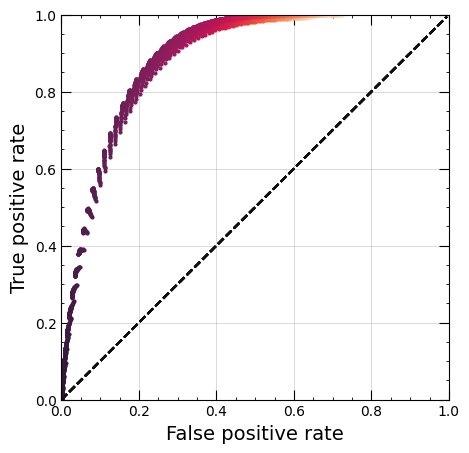

In [191]:
for fname, performance in performances.items():
    performance = performance.drop("Unnamed: 0", axis=1)
    plot_roc(fname=fname, performances=performance)

    

In [192]:
xis = {}
for fname, performance in performances.items():
    xi_match = re.search(r"xi=([\d.]+)", fname)
    xi_value = xi_match.group(1) if xi_match else None

    # Extract training period
    train_per_match = re.search(r"training_per=(\d+)", fname)
    train_per = train_per_match.group(1) if train_per_match else None

    # Display the extracted values
    xis[int(train_per)] = np.float32(xi_value)

In [193]:
xis_ordered = sorted(xis)

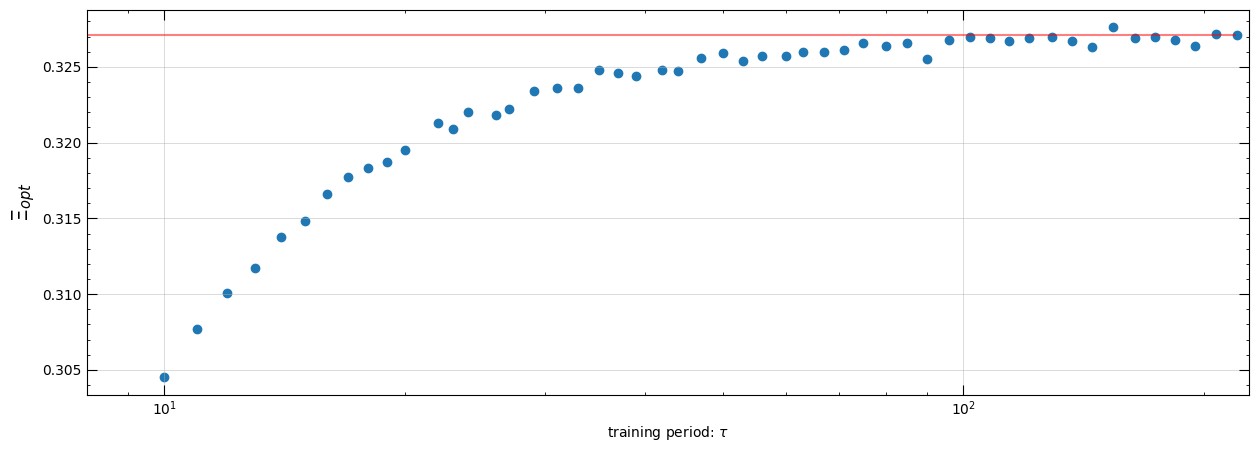

In [194]:
_ = plt.figure(figsize=(15,5))
plt.scatter(xis_ordered, [xis[x] for x in xis_ordered])
plt.plot(np.ones(xis_ordered[-1])*xis[xis_ordered[-1]], c="red", alpha=0.5)
plt.xlabel(r"training period: $\tau$", fontsize=10)
plt.ylabel(r"$\Xi_{opt}$", fontsize=15)
plt.xlim(8,xis_ordered[-1]+8)
plt.xscale("log")

plt.grid(linewidth=0.4, alpha=0.8)

plt.minorticks_on()
plt.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
plt.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)